# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Feifan Deng, Jade Ducharme, Zacharias Escalante, Soren Helhoski, Shi Yan*

The goal of this project is to perform a linear regression task on clusters of galaxy in order to infer, based on seven distinct features, the redshift of each. 

To this end, in this notebook we instantiate and train four different deep-learning models:

1. Fully-connected neural network
2. 1D convolutional neural network
3. Graph attention network
4. kNN regression model

We compare and contrast these models both qualitatively using training/validation loss curves and predicted redshift vs. true redshift plots, and quantitatively using the mean-squared error criterion for the loss and the R$^2$ linear coefficient of determination metric for accuracy.

In [3]:
# import necessary packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"    # in case of library conflict, was unable to run program without this (Feifan)

import numpy as np
import time
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as GraphDataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Non-ML Baseline

As a first step, we want to get a sense of how current non-ML methods perform on this task. Soren has gathered some examples of redshift predictions using the photoz method. We plot the non-ML predictions as a function of true (spectroscopic) redshift along with the best-fit line and linear regression statistics, computed using ```scipy```. The ```mode``` and ```zmax``` parameters in the ```load``` function are explained a little further in this notebook.

----------------- Linear Regression Parameters -----------------
Slope:					 0.7749786599967133
Intercept:				 0.09488197736421511
Coefficient of determination (R2):	 0.594149957427952
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.002767528232247858


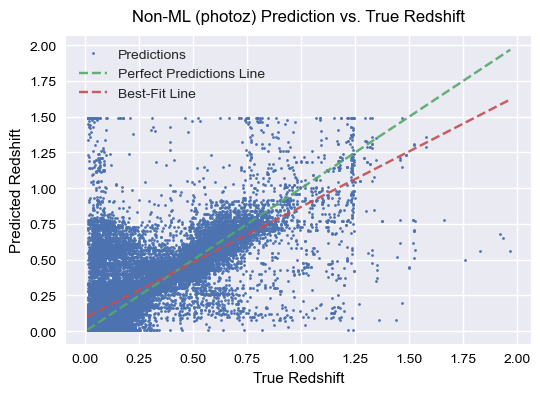

In [5]:
from src.preprocess import load
from src.visualize import visualize_predictions

old_z, true_z, features = load("./data/specz_photoz.csv", mode="all", zmax=2)

visualize_predictions(true_z.flatten(), old_z.flatten(), "Non-ML (photoz)", 
                      #savepath="./photoz_preds.png",
                      #transparent=True,
                      )

## Preprocessing

Here, we load in the clean data. The "dirty" data is cleaned in the accompanying ```make_clean_data.ipynb``` notebook. The ```load``` function simply takes in the file name and returns the data and label arrays.

Our data contains feature values (magnitudes) and their accompanying errors. Using the ```mode``` parameter, we specify whether to load only the magnitude, only the errors, or everything at once. We ultimately decided to train only on the values, although future work could focus on including the errors (either for data augmentation or as part of the loss function, for example).

After an initial run showed that our models perform poorly on statistical outliers, we implemented a hard-coded ```zmax``` redshift cut-off and set it to 2. This only removes a handful of data points, but significantly improves performance.

In [9]:
data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag", zmax=2)

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51255, 7)
Label size [input_size,]:		 (51255,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

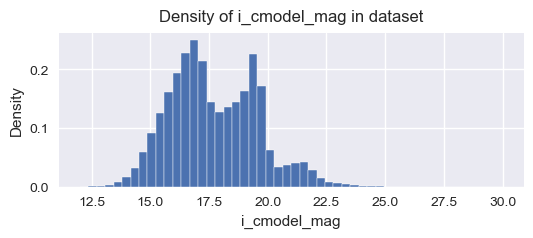

In [12]:
from src.visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))  # toggle plot_feature

Next, we can also view how our labels align with any of the features in a 2D plot. Since we have found them to be roughly linear with redshift, we also plot the best-fit line and linear regression statistics, computed using ```scipy```.

----------------- Linear Regression Parameters -----------------
Slope:					 0.09725995070341201
Intercept:				 -1.4474894736850097
Coefficient of determination (R2):	 0.5888371062143175
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.0003589911742883625


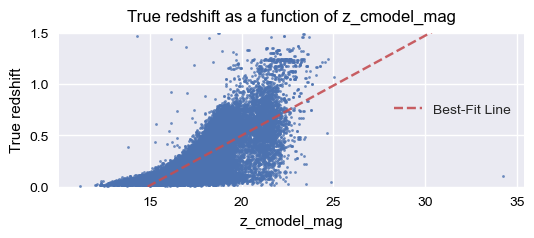

In [15]:
from src.visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5),  # toggle plot_feature
                    #  transparent=True,
                    #  savepath="./z_cmodel_mag.png",
                     )

## Model 1: FCNN

In [6]:
# FCNN global variables
BATCH_SZ = 256
LR = 1e-4  # learning rate
NE = 40  # number of epochs

The ```preprocess_split``` function takes in our data and labels, performs basic standardization across features (mean=0, std=1), and randomly splits them into training, validation, and test sets using a 70-15-15 split.

The FCNN model and its training loop are defined in ```model.py```

In [7]:
from src.preprocess import preprocess_split, time_elapsed
from src.model import SimpleFCNN, run_model

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=LR)

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

simple_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

loss_list = []
val_loss_list = []

t0 = time.time()
for e in range(1,NE+1):

    # training
    loss = run_model(simple_fcnn, "fcnn", device, train_loader, criterion, optimizer, train=True)
    loss_list.append(loss)

    # validation
    val_loss = run_model(simple_fcnn, "fcnn", device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t "\
            +f"Val loss: {val_loss:.4f}\t t elapsed: {time_elapsed(t0,time.time())} mins")

Device: cpu
Epoch 05	 Train loss: 0.0134	 Val loss: 0.0210	 t elapsed: 0.07 mins
Epoch 10	 Train loss: 0.0113	 Val loss: 0.0166	 t elapsed: 0.13 mins
Epoch 15	 Train loss: 0.0106	 Val loss: 0.0184	 t elapsed: 0.18 mins
Epoch 20	 Train loss: 0.0101	 Val loss: 0.0121	 t elapsed: 0.23 mins
Epoch 25	 Train loss: 0.0096	 Val loss: 0.0119	 t elapsed: 0.29 mins
Epoch 30	 Train loss: 0.0095	 Val loss: 0.0120	 t elapsed: 0.34 mins
Epoch 35	 Train loss: 0.0091	 Val loss: 0.0111	 t elapsed: 0.39 mins
Epoch 40	 Train loss: 0.0090	 Val loss: 0.0099	 t elapsed: 0.45 mins


In [8]:
# How does the model perform on unseen data?
test_loss = run_model(simple_fcnn, "fcnn", device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}")

Final test loss: 0.0098


We can plot the training and validation loss curves:

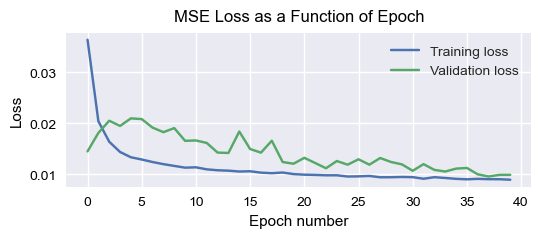

In [9]:
from src.visualize import plot_loss

plot_loss(loss_list, val_loss_list,
#           transparent=True,
#           savepath="./fcnn_loss_curve.png",
          )

Finally, we can plot the predictions on the test set as a function of true (spectroscopic) redshift:

----------------- Linear Regression Parameters -----------------
Slope:					 0.6815342063048208
Intercept:				 0.05069994564807234
Coefficient of determination (R2):	 0.869402274836155
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.0030127745737885342


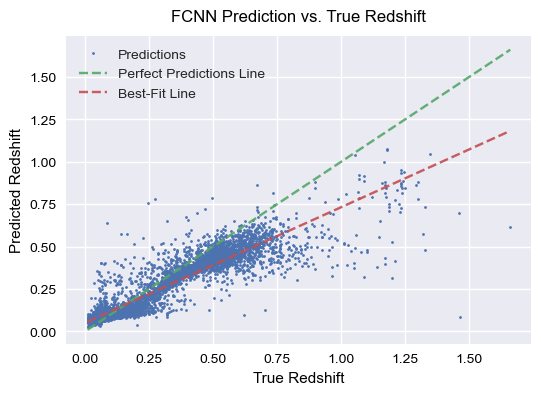

In [10]:
from src.model import get_predictions

test_labels, test_preds = get_predictions(test_set, simple_fcnn, device=device, model_type='fcnn')

visualize_predictions(test_labels, test_preds, "FCNN", 
                      #savepath="./fcnn_preds.png", 
                      #transparent=True,
                      )

## Model 2: 1D CNN

In [18]:
from src.preprocess import preprocess_split
from src.model import train1D, test1D, Simple1DCNN

# model initialization
model = Simple1DCNN(num_features=len(features), num_classes=1)

# Define the loss function and optimizer with weight decay
weight_decay = 1e-6  # Adjust this value as needed
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.000001)
acc_metric = torchmetrics.MeanAbsoluteError()

# Determine the device (CPU or GPU) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The device is determined based on the availability of CUDA (GPU support) using torch.device.

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

# Train the model
num_epochs = 40

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

for e in range(1,num_epochs+1):

    # training
    loss, acc = train1D(model, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test1D(model, device, test_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch {e}: Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1: Train Loss: 0.1125, Train Acc: 0.0536, Val Loss: 0.1004, Val Acc: 0.0581
Epoch 2: Train Loss: 0.0878, Train Acc: 0.0674, Val Loss: 0.0778, Val Acc: 0.0785
Epoch 3: Train Loss: 0.0670, Train Acc: 0.0909, Val Loss: 0.0588, Val Acc: 0.1034
Epoch 4: Train Loss: 0.0499, Train Acc: 0.1169, Val Loss: 0.0435, Val Acc: 0.1299
Epoch 5: Train Loss: 0.0365, Train Acc: 0.1440, Val Loss: 0.0320, Val Acc: 0.1568
Epoch 6: Train Loss: 0.0267, Train Acc: 0.1710, Val Loss: 0.0237, Val Acc: 0.1834
Epoch 7: Train Loss: 0.0201, Train Acc: 0.1968, Val Loss: 0.0186, Val Acc: 0.2080
Epoch 8: Train Loss: 0.0165, Train Acc: 0.2197, Val Loss: 0.0161, Val Acc: 0.2282
Epoch 9: Train Loss: 0.0149, Train Acc: 0.2364, Val Loss: 0.0152, Val Acc: 0.2413
Epoch 10: Train Loss: 0.0144, Train Acc: 0.2460, Val Loss: 0.0148, Val Acc: 0.2477
Epoch 11: Train Loss: 0.0142, Train Acc: 0.2499, Val Loss: 0.0147, Val Acc: 0.2503
Epoch 12: Train Loss: 0.0140, Train Acc: 0.2517, Val Loss: 0.0146, Val Acc: 0.2512
Epoch 13: Tra

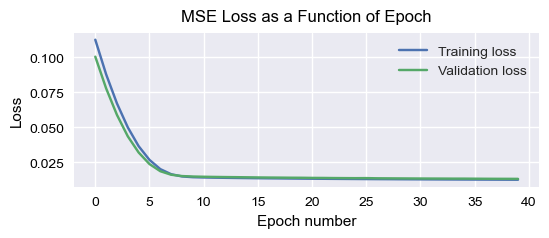

In [20]:
from src.visualize import plot_loss

plot_loss(loss_list, val_loss_list)

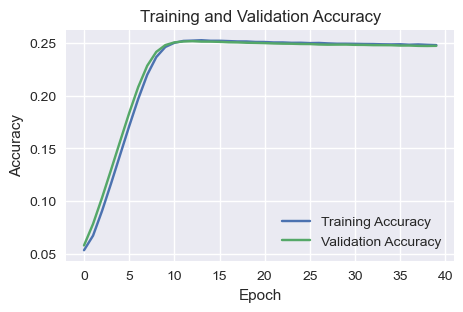

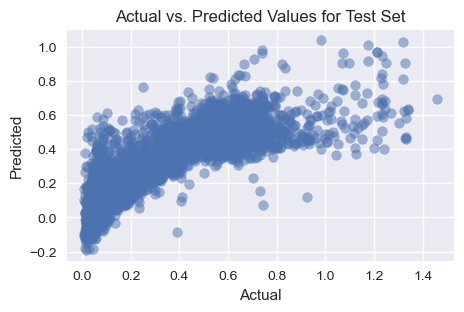

In [22]:
# Plot training and validation accuracy curves
plt.figure(figsize=(5, 3))
plt.plot(acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot actual vs. predicted values for the test set
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())

plt.figure(figsize=(5, 3))
plt.scatter(targets, predictions, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values for Test Set')
plt.show()


----------------- Linear Regression Parameters -----------------
Slope:					 0.7464278416726245
Intercept:				 0.06164069842047651
Coefficient of determination (R2):	 0.7620134658841848
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.004757778930727112


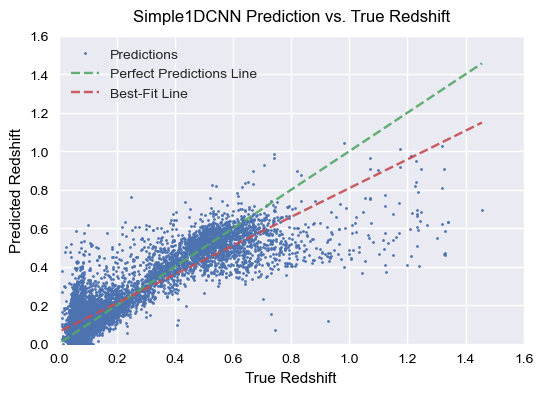

In [24]:
from src.model import get_predictions
from src.visualize import visualize_predictions


test_labels, test_preds = get_predictions(test_set, model, device=device, model_type='Simple1DCNN')

visualize_predictions(test_labels, test_preds, "Simple1DCNN", xrange=[0,1.6], yrange=[0,1.6],
                      #savepath="./1dcnn_preds_1.png", 
                      #transparent=True,
                      )



## Model 3: Graph Attention Network

We settled on the hyperparameters shown below after some tuning.

In [14]:
# GAT global variables

BATCH_SZ = 256
LR = 1e-3  # learning rate
NUM_HEADS = 1 # number of attention heads
NH = 32  # size hidden dimensions
DECAY = 1e-5  # weight decay for L2 regularization
NE = 15  # number of epochs

In order to create the graphs, the data need to be reshaped in order to explicitly show that each of our seven features should correspond to one node.

In [15]:
# Reshape data into [input_size, num_nodes, num_features_per_node] (for graphs)

graph_data = data[:,:,np.newaxis]

print("Data shape [input_size, num_nodes, num_features_per_node]:\t", graph_data.shape)

Data shape [input_size, num_nodes, num_features_per_node]:	 (51255, 7, 1)


The graphs are then created using the kNN algorithm with 6 neighbors to ensure that all nodes are connected to all other nodes in a given graph. Standardization across features (mean=0, std=1) is applied to the data array before it is turned into graphs.

In [16]:
from src.preprocess import prepare_graphs

graphs = prepare_graphs(graph_data, labels, k=6, device=device, batch_size=128)

/Users/jmduchar/anaconda3/envs/final_project/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 401/401 [00:02<00:00, 170.46it/s]


We can visualize our graphs below. Since our nodes only have one feature each, we decided to plot the node index on the y-axis in order to obtain a 2D visualization. The x-axis corresponds to the node feature value.

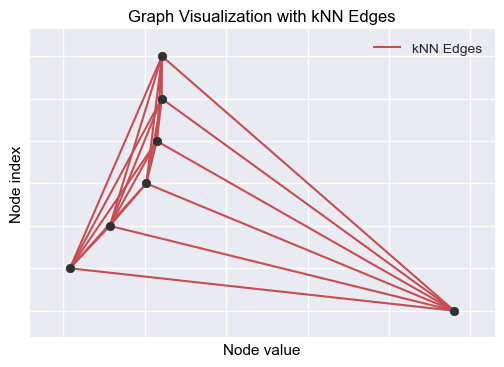

In [17]:
from src.visualize import visualize_graph

visualize_graph(graphs[42],
            #    transparent=True,
            #    savepath="./graph_viz.png",
               )

The GAT architecture is defined in ```model.py```. We choose the AdamW optimizer due to its ability to include L2 regularization, which helps with overfitting considering our small input size and relatively simple data structure.

In [18]:
from src.model import GATRegression
from src.preprocess import split_graphs

gat_model = GATRegression(num_features=1, hidden_dim=NH, num_heads=NUM_HEADS)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(gat_model.parameters(), lr=LR, weight_decay=DECAY)

# Data preparation
train_set, val_set, test_set = split_graphs(graphs, 0.7, 0.15)

train_loader = GraphDataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
val_loader = GraphDataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
test_loader = GraphDataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

loss_list = []
val_loss_list = []

t0 = time.time()
for epoch in range(1,NE+1):

    loss = run_model(gat_model, "gat", device, train_loader, criterion, optimizer=optimizer, train=True)
    loss_list.append(loss)

    # validation
    val_loss = run_model(gat_model, "gat", device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)

    if epoch%5 == 0:
        print(f"E {epoch:02d}\t Train loss: {loss:.4f}\t "\
            + f"Val loss: {val_loss:.4f}\t t elapsed: {time_elapsed(t0,time.time())} mins"
    )

E 05	 Train loss: 0.0153	 Val loss: 0.0140	 t elapsed: 0.18 mins
E 10	 Train loss: 0.0149	 Val loss: 0.0140	 t elapsed: 0.36 mins
E 15	 Train loss: 0.0148	 Val loss: 0.0148	 t elapsed: 0.54 mins


In [19]:
# How does the model perform on unseen data?
test_loss = run_model(gat_model, "gat", device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}")

Final test loss: 0.0143


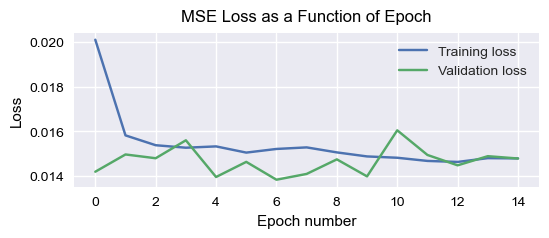

In [20]:
plot_loss(loss_list, val_loss_list,
        #  transparent=True,
        #  savepath="./gat_loss_curve.png",
         )

----------------- Linear Regression Parameters -----------------
Slope:					 0.7251712585244837
Intercept:				 0.06466740314073077
Coefficient of determination (R2):	 0.7404558705062446
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.004896865291973329


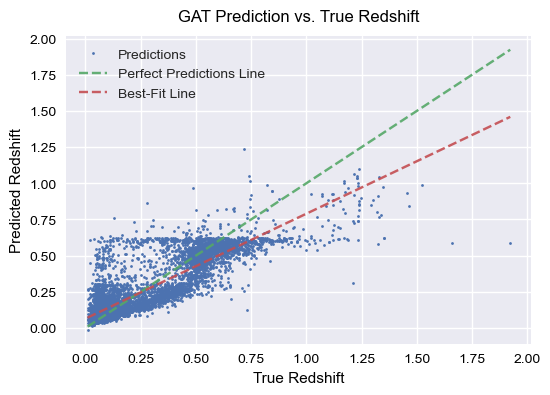

In [21]:
test_labels, test_preds = get_predictions(test_set, gat_model, device=device, model_type='gat')

visualize_predictions(test_labels, test_preds, "GAT", 
                    #   savepath="./gat_preds.png", 
                    #   transparent=True,
                      )

## Model 4: K-Nearest Neighbors Regression

In [22]:
# Information about data

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag") #Load in data

# print("Data shape [input_size, num_features]:\t", data.shape) #Get data attributes
# print("Label size [input_size,]:\t\t", labels.shape,"\n")
# print("Feature names:", features)
# print(data)

Test mse minmax: 0.016498626809961857
Optimal k minmax: 31
Test mse standard: 0.025876907496072597
Optimal k standard: 36
Test mse robust: 0.020407106224408805
Optimal k robust: 56


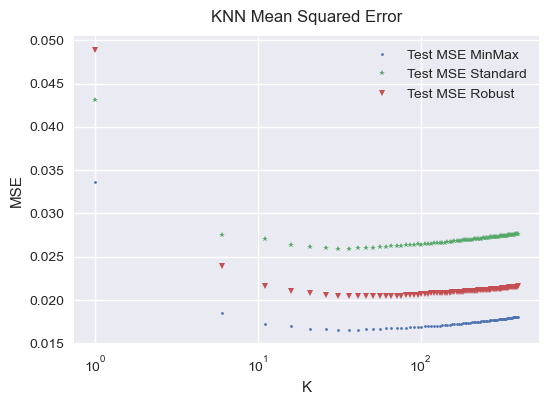

test mse mimax: 0.016498626809961857


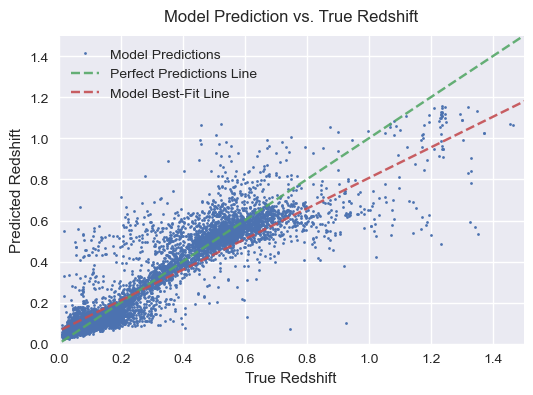

test mse standard: 0.025876907496072597


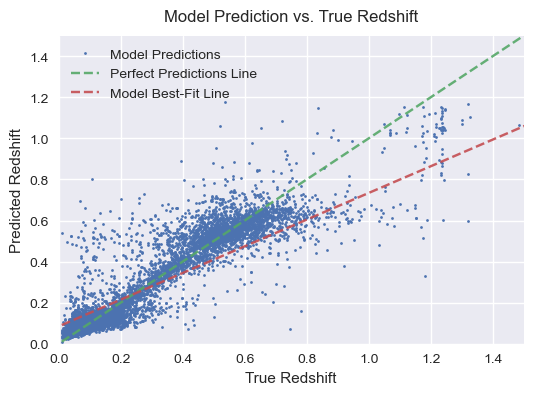

test mse robust: 0.020407106224408805


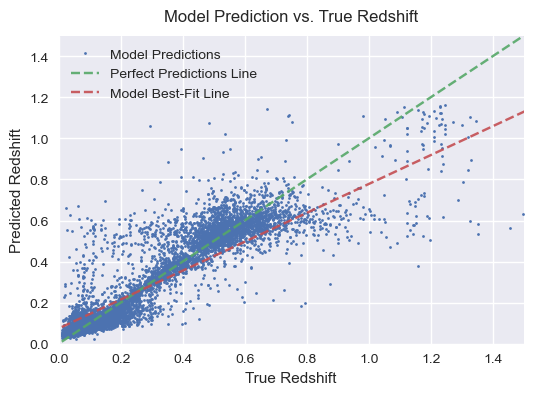

In [23]:
# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from src.visualize import visualize_knn_predictions

minmax_scaler = MinMaxScaler() #Method of scaling feature values
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

    # test_mse.append(mean_squared_error(test_labels, y_pred))

data_rescaled_minmax = minmax_scaler.fit_transform(data) #Scale feature data to lie in (0,1)
data_rescaled_standard = standard_scaler.fit_transform(data)
data_rescaled_robust = robust_scaler.fit_transform(data)

X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(data_rescaled_minmax, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(data_rescaled_standard, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(data_rescaled_robust, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)

k_vals = range(1, 400, 5) #Range of k neighbors to try

# Training

def knn_regression(train_data, test_data, train_labels, test_labels, k):
    knn = KNeighborsRegressor(n_neighbors = val, weights = "distance") #Default weights are "uniform". "distance" weight points by the inverse of their distance.
    knn.fit(train_data, train_labels)

    y_pred = knn.predict(test_data)

    return mean_squared_error(test_labels, y_pred) #Returns mse

test_mse_minmax = []; test_mse_standard = []; test_mse_robust = [];


for val in k_vals:
    test_mse_minmax.append(knn_regression(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax, k = val))
    test_mse_standard.append(knn_regression(X_train_standard, X_test_standard, y_train_standard, y_test_standard, k = val))
    test_mse_robust.append(knn_regression(X_train_robust, X_test_robust, y_train_robust, y_test_robust, k = val))

k_opt_minmax = k_vals[test_mse_minmax.index(min(test_mse_minmax))] 
k_opt_standard = k_vals[test_mse_standard.index(min(test_mse_standard))] 
k_opt_robust = k_vals[test_mse_robust.index(min(test_mse_robust))] 

print(f'Test mse minmax: {test_mse_minmax[test_mse_minmax.index(min(test_mse_minmax))]}')
print(f'Optimal k minmax: {k_opt_minmax}')

print(f'Test mse standard: {test_mse_standard[test_mse_standard.index(min(test_mse_standard))]}')
print(f'Optimal k standard: {k_opt_standard}')

print(f'Test mse robust: {test_mse_robust[test_mse_robust.index(min(test_mse_robust))]}')
print(f'Optimal k robust: {k_opt_robust}')

# KNN Visualization

plt.figure(figsize=(6,4))
plt.title("KNN Mean Squared Error", y=1.02)
plt.semilogx(k_vals, test_mse_minmax, linestyle="", marker=".", markersize=4, label="Test MSE MinMax")
plt.semilogx(k_vals, test_mse_standard, linestyle="", marker="*", markersize=4, label="Test MSE Standard")
plt.semilogx(k_vals, test_mse_robust, linestyle="", marker="v", markersize=4, label="Test MSE Robust")
plt.xlabel("K")
plt.ylabel("MSE")

# plt.xlim(xrange[0], xrange[1])
# plt.ylim(yrange[0], yrange[1])

plt.legend()
plt.show()

knn_opt_minmax = KNeighborsRegressor(n_neighbors = k_opt_minmax, weights = "distance")
knn_opt_minmax.fit(X_train_minmax, y_train_minmax)
y_opt_pred_minmax = knn_opt_minmax.predict(X_test_minmax)

knn_opt_standard = KNeighborsRegressor(n_neighbors = k_opt_standard, weights = "distance")
knn_opt_standard.fit(X_train_standard, y_train_standard)
y_opt_pred_standard = knn_opt_standard.predict(X_test_standard)

knn_opt_robust = KNeighborsRegressor(n_neighbors = k_opt_robust, weights = "distance")
knn_opt_robust.fit(X_train_robust, y_train_robust)
y_opt_pred_robust = knn_opt_robust.predict(X_test_robust)

print(f'test mse mimax: {mean_squared_error(y_test_minmax, y_opt_pred_minmax)}')
visualize_knn_predictions(y_test_minmax, y_opt_pred_minmax, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse standard: {mean_squared_error(y_test_standard, y_opt_pred_standard)}')
visualize_knn_predictions(y_test_standard, y_opt_pred_standard, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse robust: {mean_squared_error(y_test_robust, y_opt_pred_robust)}')
visualize_knn_predictions(y_test_robust, y_opt_pred_robust, device = device, xrange=(0,1.5), yrange=(0,1.5))